In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

from scipy.stats import f_oneway
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import kstest, norm
import scipy.stats as stats
from scipy.stats import spearmanr
from sklearn.preprocessing import PowerTransformer
from scipy.stats import kruskal

# 차원 축소
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 군집
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

# 학습 모델 저장을 위한 라이브러리
import pickle

In [3]:
# 사후검정을 위해 설치
!pip install scikit-posthocs

### 가설4 : 미납금액이 클수록 고객은 D 또는 E 등급일 확률이 높다

In [2]:
# 데이터를 불러온다.
df = pd.read_parquet("data/r05.parquet")
# df

In [3]:
# 필요한 컬럼 추출
df_g4 = df[['Segment', '청구금액_B0', '정상입금원금_B0M']].dropna()

In [4]:
# 파생변수 생성 : 미납금액_B0
df_g4['미납금액_B0'] = df_g4['청구금액_B0'] - df_g4['정상입금원금_B0M']

### 정규성 확인을 위한 히트맵 시각화
 - 히스토그램을 통해 segment별 분포를 확인하여 정규성 확인해보기

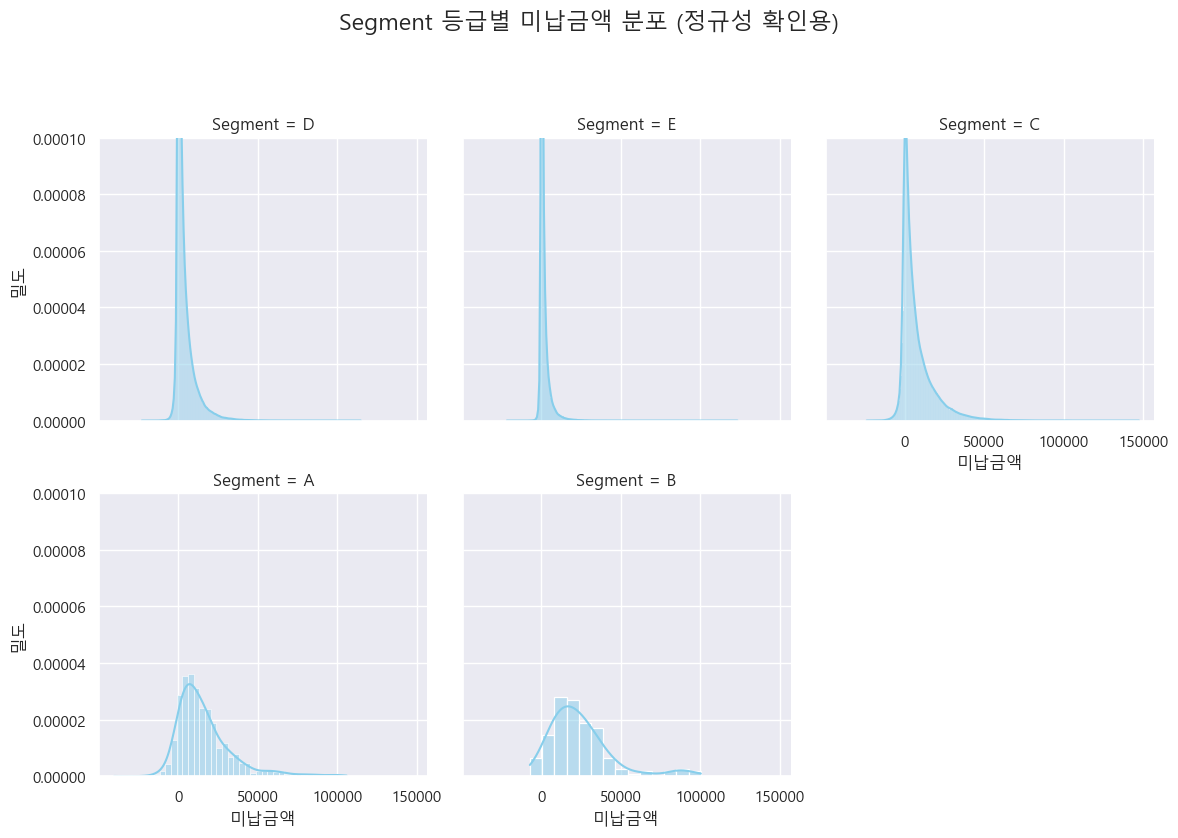

In [7]:
# Segment 등급별 분포 확인
g = sns.FacetGrid(df_g4, col="Segment", col_wrap=3, height=4, sharex=True, sharey=True)
g.map(sns.histplot, "미납금액_B0", kde=True, stat="density", color='skyblue')

# y축 밀도 범위 제한
g.set(ylim=(0, 0.0001))

# 제목 조정
g.fig.suptitle("Segment 등급별 미납금액 분포 (정규성 확인용)", y=1.05)
g.set_axis_labels("미납금액", "밀도")
plt.tight_layout()
plt.show()

### Q-Q plot
 - 히트맵 시각화에 추가적으로 Q-Q plot을 통해 정규성 확인
 - Segment 그룹별 정규성 확인

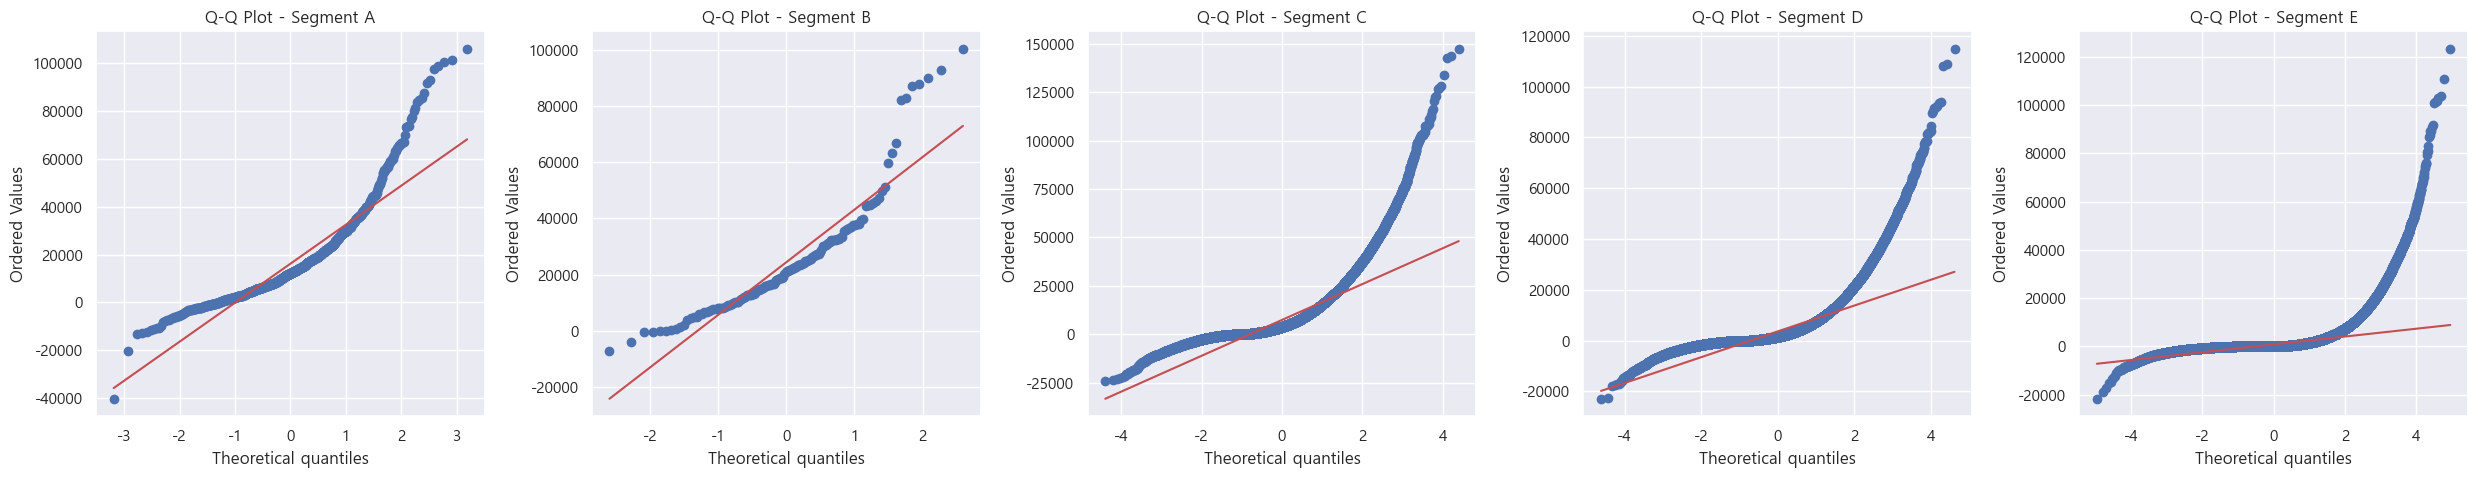

In [9]:
# Segment별 Q-Q Plot
segments = df_g4['Segment'].unique()
num_segments = len(segments)

plt.figure(figsize=(5 * num_segments, 5))

for i, seg in enumerate(sorted(segments)):
    plt.subplot(1, num_segments, i + 1)
    stats.probplot(
        df_g4[df_g4['Segment'] == seg]['미납금액_B0'], 
        dist="norm", 
        plot=plt
    )
    plt.title(f"Q-Q Plot - Segment {seg}")

plt.tight_layout()
plt.show()

In [5]:
# 등급을 수치로 매핑 (예: A=5, ..., E=1)
segment_map = {'A': 5, 'B': 4, 'C': 3, 'D': 2, 'E': 1}
df_g4['Segment_score'] = df_g4['Segment'].map(segment_map)

# Spearman 상관분석
from scipy.stats import spearmanr
corr, p = spearmanr(df_g4['Segment_score'], df_g4['미납금액_B0'])
print(f'Spearman 상관계수: {corr:.4f}, p-value: {p:.4f}')

Spearman 상관계수: 0.3108, p-value: 0.0000


### 가설3 : Kruskal-Wallis H-test

### Kruskal-Walli H-test란?
 - 비모수 분산분석 방법
 - 3개 이상의 집단 간 중앙값 차이에 대한 검정방법
 - 정규성, 등분산성을 만족하지 않아도 됨
 - 범주형 독립변수(Segment), 연속형 종속변수(이용금액_일시불_R3M)에 적합
 - 귀무가설(H0) : 모든 Segment 등급 그룹의 카드 이용금액_일시불_R3M 분포는 동일하다.
 - 대립가설(H1) : 적어도 하나의 그룹은 다른 그룹과 통계적으로 다른 분포를 가진다.

In [11]:
# Segment별로 금액을 리스트로 분리
grouped_data = [
    df_g4[df_g4['Segment'] == seg]['미납금액_B0'].dropna()
    for seg in sorted(df_g4['Segment'].unique())
]

In [11]:
# Kruskal-Wallis H-test 수행
stat, p = kruskal(*grouped_data)

# 결과값 출력
print(f"Kruskal-Wallis H-statistic: {stat:.4f}")
print(f"p-value: {p:.4f}")

if p < 0.05:
    print("→ 유의미한 차이가 있음. 귀무가설 기각됨")
else:
    print("→ 유의미한 차이가 없음. 귀무가설 채택.")

Kruskal-Wallis H-statistic: 474283.1740
p-value: 0.0000
→ 유의미한 차이가 있음. 귀무가설 기각됨


- Segment 등급별로 당월 정상입금원금의 분포에 유의미한 차이가 있음을 통계적으로 확인함.

### 사후검정(Dunn's test)
 - Kruskal-Wallis H-test를 통해 등급별 당월 정상입금원금의 분포에 유의미한 차이가 있음을 확인하였음
 - 이후에 어떤 Segment 간에 차이가 있는지 구체적으로 파악

In [12]:
import scikit_posthocs as sp

# 사후검정 실시
sp.posthoc_dunn(df_g4, val_col='미납금액_B0', group_col='Segment', p_adjust='bonferroni')

,A,B,C,D,E
A,1.000000e+00,1.439148e-02,5.596994e-34,8.739843e-108,0.000000e+00
B,1.439148e-02,1.000000e+00,2.904191e-15,6.293521e-32,4.576526e-89
C,5.596994e-34,2.904191e-15,1.000000e+00,0.000000e+00,0.000000e+00
D,8.739843e-108,6.293521e-32,0.000000e+00,1.000000e+00,0.000000e+00
E,0.000000e+00,4.576526e-89,0.000000e+00,0.000000e+00,1.000000e+00


- 표에서 행, 열은 Segment 간 비교이다.
- p < 0.05 일수록, 두 그룹 간 이용금액에 유의미한 차이가 있다.
- 값이 1인 경우는 동일 그룹간의 비교 혹은 다른 그룹일 경우 통계적으로 유의미한 차이가 없다라는 의미를 가진다.

### 사후검정 결론 (Boxplot 결과 포함) - 수정중